## REQUIREMENTS

In [14]:
import numpy as np
import pandas as pd
import seaborn as sn
x = np.random.randn(5,2)
x_s,y_s = x.shape

In [18]:
from sklearn.metrics import confusion_matrix

In [21]:
# from mlxtend.evaluate import confusion_matrix

y_target =    [[0, 0, 1, 0, 0, 1, 1, 1],[0, 0, 1, 0, 0, 1, 1, 1]]
y_predicted = [[1, 0, 1, 0, 0, 0, 0, 1],[0, 0, 1, 0, 0, 1, 1, 1]]

cm = confusion_matrix(y_target,y_predicted)
cm

ValueError: multilabel-indicator is not supported

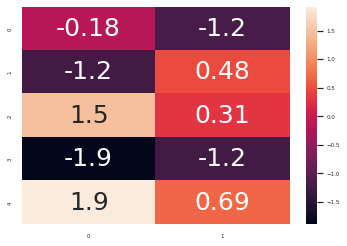

In [15]:
df_cm = pd.DataFrame(x, range(x_s), range(y_s))
sn.set(font_scale=0.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 25}) # font size

In [8]:
import sys
sys.path.append("/content/drive/MyDrive/DL_projects/text_classification/src")

In [2]:
import sys 
import json
import torch
import nltk
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
import gensim
import config
import helper
from sklearn.model_selection import train_test_split
from model import ClassifierModel
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
sw = stopwords.words('english')
from gensim.models import KeyedVectors
import model
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
config.local_base_dir = "/content/drive/MyDrive/DL_projects/text_classification/"
config.local_train_file = "dataset/imdb_dataset.csv"
config.prep_train_test_vocabed = "imdb_train_test_vocabed.pkl"
config.EMBED_SIZE = 32

In [44]:
data = pd.read_csv(config.local_base_dir +config.local_train_file)

In [45]:
mapping = {"positive" : 1,"negative":0}
data['sentiment'] = data['sentiment'].map(mapping) 
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## PREPROCESSING

In [46]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r"^[A-Za-z]","",text)
    # text = " ".join([x for x in text.split() if x not in sw])
    # text = " ".join([wordnet_lemmatizer.lemmatize(x) for x in text.split() ])
    # # text = " ".join([porter_stemmer.stem(x) for x in text.split()])
    # text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

In [47]:
def data_length(dataframe):
    all_words = set()
    all_sentence = list()
    for sentence in dataframe["prep_data"]:
        all_sentence.append(sentence.lower().split())
        for word in sentence.lower().split():
            all_words.add(word)
    len_all_words = len(all_words)
    len_all_sentence = len(all_sentence)
    print(f"Total number of words : {len_all_words}")
    print(f"Total number of sentence : {len_all_sentence}")
    print()
    return all_words,all_sentence

In [48]:
if __name__ == "__main__":
    prep_data = data["review"].apply(lambda x : preprocess_text(x)) 
    data["prep_data"] = prep_data
    all_words,all_sentence = data_length(data)
    samples_lbl = data["sentiment"]
    X_train, X_test, y_train, y_test = train_test_split(all_sentence,samples_lbl,test_size=0.2,shuffle=True)


Total number of words : 394208
Total number of sentence : 50000



In [49]:
data.head()

,review,sentiment,prep_data
0,One of the other reviewers has mentioned that ...,1,ne of the other reviewers has mentioned that a...
1,A wonderful little production. <br /><br />The...,1,wonderful little production. <br /><br />the ...
2,I thought this was a wonderful way to spend ti...,1,thought this was a wonderful way to spend tim...
3,Basically there's a family where a little boy ...,0,asically there's a family where a little boy (...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"etter mattei's ""love in the time of money"" is ..."


In [50]:
data['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [51]:

pickle.dump({
    "X_train" : X_train,
    "X_test" : X_test,
    "y_train" : y_train.values.tolist(),
    "y_test" : y_test.values.tolist(),
},open(config.local_base_dir + "dataset/"+ config.prep_train_test_vocabed,'wb'))



In [52]:
config.local_base_dir + "dataset/"+ config.prep_train_test_vocabed

'/content/drive/MyDrive/DL_projects/text_classification/dataset/imdb_train_test_vocabed.pkl'

In [53]:
split_data = pickle.load(open(config.local_base_dir + "dataset/"+ config.prep_train_test_vocabed,'rb'))

# **Word to Vectors**

In [54]:
def build_word2vec(all_sentence,embedding_size):
    w2v_model = gensim.models.Word2Vec(sentences=all_sentence,min_count=1,vector_size= embedding_size)
    w2v_model.build_vocab(all_sentence)
    print("Length of samples : ",w2v_model.corpus_count)
    print("Length of vocab   : ",len(w2v_model.wv.key_to_index))
    print("Training and saving model...")
    w2v_model.train(all_sentence,total_examples=w2v_model.corpus_count,epochs=w2v_model.epochs)
    w2v_model.save(f"{config.local_base_dir}dataset/prep_word2vectors_{config.EMBED_SIZE}.model")
    wordvecs = KeyedVectors.load(f"{config.local_base_dir}dataset/prep_word2vectors_{config.EMBED_SIZE}.model")    
    all_words = list(wordvecs.wv.key_to_index.keys())
# wordvecs.wv.index_to_key = {v:k for k,v in wordvecs.wv.key_to_index.items()}
    word2index = {k:v+1 for k,v in wordvecs.wv.key_to_index.items()}
    index2word = {v:k for k,v in word2index.items()}
    
    matrix_vec = np.zeros((len(word2index)+1,config.EMBED_SIZE))
    for word,idx in word2index.items():
        vector_x = wordvecs.wv[word]
        matrix_vec[idx,:] = vector_x    
    pickle_data = {
    "word2index" : word2index,
    "index2word" : index2word,
    "embedding_vector" : matrix_vec
    }
    pickle.dump(pickle_data,open(config.local_base_dir+"dataset/prep_emb_vec.pkl",'wb'))
    print("Done")
    print(f'Model saved to {config.local_base_dir+"dataset/prep_emb_vec.pkl"}')
    

In [55]:
config.EMBED_SIZE = 32
build_word2vec(all_sentence,config.EMBED_SIZE)

Length of samples :  50000
Length of vocab   :  394208
Training and saving model...
Done
Model saved to /content/drive/MyDrive/DL_projects/text_classification/dataset/prep_emb_vec.pkl


In [2]:
import pickle

In [3]:
pickle_data =pickle.load(open("/content/drive/MyDrive/DL_projects/text_classification/trained_models/seq2seq_hidden_32_embed_32_imdb_word2vec.pt",'rb'))

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [57]:
word2index = pickle_data['word2index']
index2word = pickle_data['index2word']
word_vectors = pd.DataFrame(pickle_data['embedding_vector'])
word_vectors = word_vectors.iloc[:1000,:]
word_vectors.to_csv("imdb_embedding_matrix.tsv",sep ="\t",header = None,index = False)
index2word[0] = "[PAD]"
only_words = [index2word[x] for x in range(len(index2word))]
word_vectors["metadata"] =only_words
word_vectors.to_csv("imdb_meta_data.tsv",sep ="\t",index = False)

In [58]:
word_vectors = word_vectors.iloc[:1000,:]

(1000, 33)

In [38]:
import sys
import torch
import pickle

sys.path.append("/content/drive/MyDrive/DL_projects/text_classification/src")

In [39]:

checkpoint = torch.load("/content/drive/MyDrive/DL_projects/text_classification/trained_models/seq2seq_hidden_32_embed_32_imdb_prep_word2vec.pt")
checkpoint.keys()

dict_keys(['model_state_dict', 'params'])

In [40]:
params = checkpoint['params']
pickle_data =pickle.load(open(params["base_dir"] +params["emb_vec_file"],'rb'))
pickle_data.keys()

word2index = pickle_data['word2index']
index2word = pickle_data['index2word']

In [41]:
# n_vocab,hidden_size,out_hidden,embedding_dim,n_labels,max_seq
import model
my_model = model.ClassifierModel(len(word2index),params["HIDDEN_SIZE"],params["OUT_DIM"],params["EMBED_SIZE"],n_labels = params["n_labels"],max_seq=params['max_seq_len'])

In [42]:
my_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [43]:
import pandas as pd
emb_matrix = my_model.embedding.weight.detach().numpy()

In [44]:
emb = pd.DataFrame(emb_matrix)

In [45]:
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.958725,-2.012993,-1.990048,-1.875980,3.330124,-2.696292,1.574587,-2.688815,-3.183158,-1.885756,...,-0.626177,3.819112,-0.908313,-0.049486,3.113933,0.165160,-1.879725,-2.445399,-0.156372,-0.157932
2,2.715530,0.238338,-1.754464,1.052473,-0.633279,-0.596190,3.750718,-1.615034,-4.787402,1.783780,...,-0.741260,5.175512,-1.019670,-1.194044,0.738397,-1.957601,-3.177318,-2.834952,1.767297,-2.191243
3,3.593699,-2.938445,0.486397,-0.726218,2.960893,-0.602916,2.390825,-2.248037,-3.166243,-1.237077,...,0.737794,-0.942997,-2.011789,-0.670723,1.667908,-0.338682,-3.615632,-2.489557,0.348990,-1.230961
4,0.758281,-4.095868,1.659120,-2.380796,0.754716,-2.022166,2.962155,-4.156785,-2.601961,-0.019272,...,-1.192267,1.165249,-0.408238,-2.747801,2.871237,-0.324455,-0.632131,-0.466374,-2.312047,-1.023201


In [46]:
emb.shape

(394209, 32)

In [47]:
len(index2word)

394208

In [48]:
emb = emb.iloc[:10000,:]

In [49]:
emb.to_csv("imdb_prep_embedding_matrix.tsv",sep = '\t',header=None,index = False)

In [50]:
pd.read_csv("/content/drive/MyDrive/DL_projects/text_classification/src/interpret/imdb_prep_embedding_matrix.tsv",sep = '\t').head()

,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,0.0.9,...,0.0.22,0.0.23,0.0.24,0.0.25,0.0.26,0.0.27,0.0.28,0.0.29,0.0.30,0.0.31
0,2.958725,-2.012993,-1.990048,-1.875980,3.330124,-2.696292,1.574587,-2.688815,-3.183158,-1.885756,...,-0.626177,3.819112,-0.908313,-0.049486,3.113933,0.165160,-1.879725,-2.445399,-0.156372,-0.157932
1,2.715530,0.238338,-1.754464,1.052473,-0.633279,-0.596190,3.750718,-1.615034,-4.787402,1.783780,...,-0.741260,5.175512,-1.019670,-1.194044,0.738397,-1.957601,-3.177318,-2.834952,1.767297,-2.191243
2,3.593698,-2.938445,0.486397,-0.726218,2.960893,-0.602916,2.390825,-2.248037,-3.166243,-1.237076,...,0.737794,-0.942997,-2.011789,-0.670723,1.667908,-0.338682,-3.615632,-2.489557,0.348990,-1.230961
3,0.758281,-4.095868,1.659120,-2.380796,0.754716,-2.022166,2.962155,-4.156784,-2.601961,-0.019272,...,-1.192267,1.165249,-0.408238,-2.747801,2.871237,-0.324455,-0.632131,-0.466374,-2.312047,-1.023201
4,4.715492,-5.668120,-4.044202,1.723107,0.952262,0.606390,0.886648,-5.929870,1.248306,3.377407,...,0.803426,0.616652,-0.097585,2.527737,3.889546,0.377124,-4.822519,1.301059,3.585556,1.519022


In [51]:
index2word[0] = "[PAD]"

In [52]:
word_vectors = pd.read_csv("/content/drive/MyDrive/DL_projects/text_classification/src/interpret/imdb_prep_embedding_matrix.tsv",sep = '\t',header = None)
print(word_vectors.shape,len(index2word))
word_vectors.head()
print(word_vectors.shape)

(10000, 32) 394209
(10000, 32)


In [53]:
only_words = [index2word[x] for x in range(len(index2word))]

In [54]:
word_vectors.shape,len(only_words),only_words[-1]

((10000, 32), 394209, 'firm);')

In [55]:
word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.958725,-2.012993,-1.990048,-1.875980,3.330124,-2.696292,1.574587,-2.688815,-3.183158,-1.885756,...,-0.626177,3.819112,-0.908313,-0.049486,3.113933,0.165160,-1.879725,-2.445399,-0.156372,-0.157932
2,2.715530,0.238338,-1.754464,1.052473,-0.633279,-0.596190,3.750718,-1.615034,-4.787402,1.783780,...,-0.741260,5.175512,-1.019670,-1.194044,0.738397,-1.957601,-3.177318,-2.834952,1.767297,-2.191243
3,3.593698,-2.938445,0.486397,-0.726218,2.960893,-0.602916,2.390825,-2.248037,-3.166243,-1.237076,...,0.737794,-0.942997,-2.011789,-0.670723,1.667908,-0.338682,-3.615632,-2.489557,0.348990,-1.230961
4,0.758281,-4.095868,1.659120,-2.380796,0.754716,-2.022166,2.962155,-4.156784,-2.601961,-0.019272,...,-1.192267,1.165249,-0.408238,-2.747801,2.871237,-0.324455,-0.632131,-0.466374,-2.312047,-1.023201


In [56]:
only_words = only_words[:10000]

In [57]:
word_vectors["metadata"] =only_words

In [58]:
word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,metadata
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[PAD]
1,2.958725,-2.012993,-1.990048,-1.875980,3.330124,-2.696292,1.574587,-2.688815,-3.183158,-1.885756,...,3.819112,-0.908313,-0.049486,3.113933,0.165160,-1.879725,-2.445399,-0.156372,-0.157932,the
2,2.715530,0.238338,-1.754464,1.052473,-0.633279,-0.596190,3.750718,-1.615034,-4.787402,1.783780,...,5.175512,-1.019670,-1.194044,0.738397,-1.957601,-3.177318,-2.834952,1.767297,-2.191243,a
3,3.593698,-2.938445,0.486397,-0.726218,2.960893,-0.602916,2.390825,-2.248037,-3.166243,-1.237076,...,-0.942997,-2.011789,-0.670723,1.667908,-0.338682,-3.615632,-2.489557,0.348990,-1.230961,and
4,0.758281,-4.095868,1.659120,-2.380796,0.754716,-2.022166,2.962155,-4.156784,-2.601961,-0.019272,...,1.165249,-0.408238,-2.747801,2.871237,-0.324455,-0.632131,-0.466374,-2.312047,-1.023201,of


In [59]:
word_vectors.to_csv("imdb_prep_meta_data.tsv",sep ="\t",index = False)

In [60]:
pd.read_csv("imdb_prep_meta_data.tsv",sep ="\t").head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,metadata
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[PAD]
1,2.958725,-2.012993,-1.990048,-1.875980,3.330124,-2.696292,1.574587,-2.688815,-3.183158,-1.885756,...,3.819112,-0.908313,-0.049486,3.113933,0.165160,-1.879725,-2.445399,-0.156372,-0.157932,the
2,2.715530,0.238338,-1.754464,1.052473,-0.633279,-0.596190,3.750718,-1.615034,-4.787402,1.783780,...,5.175512,-1.019670,-1.194044,0.738397,-1.957601,-3.177318,-2.834952,1.767297,-2.191243,a
3,3.593698,-2.938445,0.486397,-0.726218,2.960893,-0.602916,2.390825,-2.248037,-3.166243,-1.237076,...,-0.942997,-2.011789,-0.670723,1.667908,-0.338682,-3.615632,-2.489557,0.348990,-1.230961,and
4,0.758281,-4.095868,1.659120,-2.380796,0.754716,-2.022166,2.962155,-4.156784,-2.601961,-0.019272,...,1.165249,-0.408238,-2.747801,2.871237,-0.324455,-0.632131,-0.466374,-2.312047,-1.023201,of


In [61]:
word_vectors

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,metadata
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[PAD]
1,2.958725,-2.012993,-1.990048,-1.875980,3.330124,-2.696292,1.574587,-2.688815,-3.183158,-1.885756,...,3.819112,-0.908313,-0.049486,3.113933,0.165160,-1.879725,-2.445399,-0.156372,-0.157932,the
2,2.715530,0.238338,-1.754464,1.052473,-0.633279,-0.596190,3.750718,-1.615034,-4.787402,1.783780,...,5.175512,-1.019670,-1.194044,0.738397,-1.957601,-3.177318,-2.834952,1.767297,-2.191243,a
3,3.593698,-2.938445,0.486397,-0.726218,2.960893,-0.602916,2.390825,-2.248037,-3.166243,-1.237076,...,-0.942997,-2.011789,-0.670723,1.667908,-0.338682,-3.615632,-2.489557,0.348990,-1.230961,and
4,0.758281,-4.095868,1.659120,-2.380796,0.754716,-2.022166,2.962155,-4.156784,-2.601961,-0.019272,...,1.165249,-0.408238,-2.747801,2.871237,-0.324455,-0.632131,-0.466374,-2.312047,-1.023201,of
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.054073,-1.306047,-0.225386,0.520529,-0.289925,0.499278,0.589277,0.719818,-0.478099,-0.565172,...,-0.291355,0.354963,-0.418208,-0.708060,-0.007273,-0.071855,-0.651207,0.003861,0.294426,lester
9996,1.660530,-2.385274,-2.172968,0.730488,-0.181869,0.515578,-0.059546,0.797483,-1.913517,-0.023179,...,-1.310679,0.155042,1.490086,-0.515011,-0.044432,-1.980839,0.415008,-1.998591,1.192466,encouraged
9997,-0.053825,-1.348443,1.516496,1.278098,-1.267467,0.038891,1.771448,-0.129162,1.357086,-0.926320,...,-1.756148,-0.039685,2.316189,-1.693603,0.969027,-0.361738,-1.226461,-1.539251,1.138865,8.
9998,0.276255,-0.830416,0.446468,0.560811,-0.545029,0.218184,0.850519,-0.050351,-1.521231,-0.589575,...,-0.793796,0.062207,-0.594397,-0.811170,-0.261929,0.354554,-0.946608,-0.071854,0.348152,paxton


In [62]:
test_data = pd.read_csv("/content/drive/MyDrive/DL_projects/text_classification/dataset/imdb_dataset.csv")[:100]

In [63]:
test_data.iloc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [64]:
for i in range(10):
    if test_data['sentiment'][i] == 'positive':
        print("POSITIVE")
        print(test_data.iloc[i]['review'])
        print()
    else:
        print("NEGATIVE")
        print(test_data.iloc[i]['review'])
        print()

POSITIVE
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due t

In [130]:
for i in range(5):
    if test_data[1][i] == 1:
        print("HAM")
        print(test_data[3][i])
        print()

    else:
        print("SPAM")
        print(test_data[3][i])
        print()


# test_data[3]

HAM
I have done a lot of international travel, both on business and as a tourist. For both types I assure you the best advice is also the oldest: Always drink the wine of the country. In this movie the archangel Michael comes to Earth on business, wraps it up quickly and decides to hang around for a little touring. Boy! Does he "drink the wine of the country."<br /><br />Could man be drunk forever with liquor, love and fights <br /><br />He'd lief rise up of mornings and lief lie down of nights.<br /><br />These are things you can't do in Heaven so he enjoys them while he's here! Of course it turns out he had a couple of other jobs to tackle and, if he is less direct about them than he was about the first one, he is just as successful. The final scene is a little schmaltzy but it is also wonderful. Jean Stapleton gets to dance with John Travolta.

HAM
One of the most frightening game experiences ever that will make you keep the lights on next to your bed. Great storyline with a romanti

'i am man >with ?///?'

In [30]:
text = "i am ravi score 50 ??"
text = re.sub(r"[^A-Za-z]"," ",text).strip()
re.sub(r"[^\w\s]", '', text).strip()


'i am ravi score'